[[[-2.052794    0.96943057  0.25957263]]]


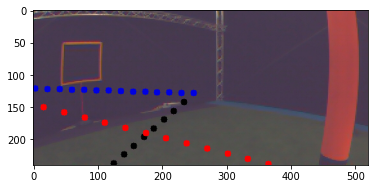

In [16]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact


image_path = r'C:\Users\Jonathan van Zyl\Documents\GitHub\paparazzi\COMPUTERVISIONSIM\Projection\single_image\image\68016093.jpg'
time_stamp = 68.016093

#image_path = r'C:\Users\Jonathan van Zyl\Documents\GitHub\paparazzi\COMPUTERVISIONSIM\Projection\single_image\image\63582791.jpg'
#time_stamp = 63.582791


# Extract data from the csv
csv_path = r'C:\Users\Jonathan van Zyl\Documents\GitHub\paparazzi\COMPUTERVISIONSIM\Projection\single_image\20190121-140303.csv'

# Extract time using pandas

df = pd.read_csv(csv_path)
time = df['time']
pos_x = df['pos_x']
pos_y = df['pos_y']
pos_z = df['pos_z']
att_phi = df['att_phi']
att_theta = df['att_theta']
att_psi = df['att_psi']

# Interpolate the data with respect to the time stamp
index = np.argmin(np.abs(time - time_stamp))

# Extract the position and attitude at the time stamp
pos_x = pos_x[index]
pos_y = pos_y[index]
pos_z = pos_z[index]
att_phi = att_phi[index]
att_theta = att_theta[index]
att_psi = att_psi[index]

# make state vector
state_vector = np.array([pos_x, pos_y, pos_z, att_phi, att_theta, att_psi])

# Rotation matrix wrt to cyberzoo frame to drone frame
def update_camera_rotation_matrix(phi, psi, theta):
            # Converting from [-pi, pi] to [0, 2pi]:
            if phi < 0:
                roll = 2 * np.pi + phi
            else:
                roll = phi
            if psi < 0:
                yaw = 2 * np.pi + psi
            else:
                roll = phi
                yaw = psi
            pitch = theta

            Rx = np.array([[1, 0, 0],
                   [0, np.cos(roll), -np.sin(roll)],
                   [0, np.sin(roll), np.cos(roll)]])

            Ry = np.array([[np.cos(pitch), 0, np.sin(pitch)],
                        [0, 1, 0],
                        [-np.sin(pitch), 0, np.cos(pitch)]])

            Rz = np.array([[np.cos(yaw), -np.sin(yaw), 0],
                        [np.sin(yaw), np.cos(yaw), 0],
                        [0, 0, 1]])

            # The order of multiplication depends on the convention used. This uses ZYX (yaw-pitch-roll).
            R = np.dot(Rz, np.dot(Ry, Rx))

            return R

'''
_OZ1: X=-1.34 m, Y=-3.37 m, Z=0 m
_OZ2: X=-4.40 m, Y=1.05 m, Z=0 m
_OZ3: X=0.44 m, Y=4.18 m, Z=0 m
_OZ4: X=3.27 m, Y=-0.41 m, Z=0 m
'''

# Define the corners of the cyberzoo in Cyberzoo frame
OZ1 = np.array([-1.34, -3.37, 0])
OZ2 = np.array([-4.40, 1.05, 0])
OZ3 = np.array([0.44, 4.18, 0])
OZ4 = np.array([3.27, -0.41, 0])

# Rotate & translate the corners into the drone frame
R = update_camera_rotation_matrix(att_phi, att_psi, att_theta)
t = np.array([pos_x, pos_y, pos_z])
OZ1 = np.dot(R, OZ1 - t)
OZ2 = np.dot(R, OZ2 - t)
OZ3 = np.dot(R, OZ3 - t)
OZ4 = np.dot(R, OZ4 - t)

'''
X_camera = Y_drone
            Y_camera = Z_drone
            Z_camera = X_drone
'''

# Define the corners of the cyberzoo in the drone frame
OZ1 = np.array([OZ1[1], OZ1[2], OZ1[0]])
OZ2 = np.array([OZ2[1], OZ2[2], OZ2[0]])
OZ3 = np.array([OZ3[1], OZ3[2], OZ3[0]])
OZ4 = np.array([OZ4[1], OZ4[2], OZ4[0]])
               

# Define the camera and distortion matrix
f_x = 300.
f_y = 300.
c_x = 350.
c_y = 200.
K = np.array([[f_x,   0.,         c_x],
            [  0.,         f_y, c_y],
            [  0.,           0.,           1.        ]])


D = np.array([[ 0.],
            [ 0. ],
            [0.],
            [ 0.]])

# Ensure the points are in the correct format
OZ1 = np.array([OZ1], dtype=np.float32).reshape(-1, 1, 3)
OZ2 = np.array([OZ2], dtype=np.float32).reshape(-1, 1, 3)
OZ3 = np.array([OZ3], dtype=np.float32).reshape(-1, 1, 3)
OZ4 = np.array([OZ4], dtype=np.float32).reshape(-1, 1, 3)

rvec_null = np.zeros((1, 1, 3), dtype=np.float32)
Tvec_null = np.zeros((1, 1, 3), dtype=np.float32)

print(OZ1)

# Fisheye project the corners
OZ1 = cv2.fisheye.projectPoints(OZ1, rvec_null, Tvec_null, K, D)
OZ2 = cv2.fisheye.projectPoints(OZ2, rvec_null, Tvec_null, K, D)
OZ3 = cv2.fisheye.projectPoints(OZ3, rvec_null, Tvec_null, K, D)
OZ4 = cv2.fisheye.projectPoints(OZ4, rvec_null, Tvec_null, K, D)

# Define the image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Rotate image
image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
# Draw the corners on the image
cv2.circle(image, (int(OZ1[0][0][0][0]), int(OZ1[0][0][0][1])), 5, (0, 255, 0), -1)
cv2.circle(image, (int(OZ2[0][0][0][0]), int(OZ2[0][0][0][1])), 5, (0, 255, 0), -1)
cv2.circle(image, (int(OZ3[0][0][0][0]), int(OZ3[0][0][0][1])), 5, (0, 255, 0), -1)
cv2.circle(image, (int(OZ4[0][0][0][0]), int(OZ4[0][0][0][1])), 5, (0, 255, 0), -1)

# Draw the interpolated points
# Interpolate points between the corners
num_points = 20
x_values = np.linspace(OZ1[0][0][0][0], OZ2[0][0][0][0], num_points)
y_values = np.linspace(OZ1[0][0][0][1], OZ2[0][0][0][1], num_points)
for i in range(num_points):
    cv2.circle(image, (int(x_values[i]), int(y_values[i])), 5, (0, 0, 0), -1) # Black : (0, 0, 0)

num_points = 20
x_values = np.linspace(OZ2[0][0][0][0], OZ3[0][0][0][0], num_points)
y_values = np.linspace(OZ2[0][0][0][1], OZ3[0][0][0][1], num_points)
for i in range(num_points):
    cv2.circle(image, (int(x_values[i]), int(y_values[i])), 5, (0, 0, 225), -1) # Red : (0, 0, 255)

num_points = 20
x_values = np.linspace(OZ3[0][0][0][0], OZ4[0][0][0][0], num_points)
y_values = np.linspace(OZ3[0][0][0][1], OZ4[0][0][0][1], num_points)
for i in range(num_points):
    cv2.circle(image, (int(x_values[i]), int(y_values[i])), 5, (255, 0, 0), -1) # Blue : (255, 0, 0)

num_points = 20
x_values = np.linspace(OZ4[0][0][0][0], OZ1[0][0][0][0], num_points)
y_values = np.linspace(OZ4[0][0][0][1], OZ1[0][0][0][1], num_points)
for i in range(num_points):
    cv2.circle(image, (int(x_values[i]), int(y_values[i])), 5, (0, 165, 255), -1)  # Orange : (0, 165, 255)

# Display the image
plt.imshow(image)
plt.show()

# Use a clicker to find pixel coordinates of the corners
# Clicker
def click_event(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        print(x, y)

#cv2.imshow('image', image)
#cv2.setMouseCallback('image', click_event)
#cv2.waitKey(0)

# 248 160



In [17]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact


image_path = r'C:\Users\Jonathan van Zyl\Documents\GitHub\paparazzi\COMPUTERVISIONSIM\Projection\single_image\image\68016093.jpg'
time_stamp = 68.016093

#image_path = r'C:\Users\Jonathan van Zyl\Documents\GitHub\paparazzi\COMPUTERVISIONSIM\Projection\single_image\image\63582791.jpg'
#time_stamp = 63.582791


# Extract data from the csv
csv_path = r'C:\Users\Jonathan van Zyl\Documents\GitHub\paparazzi\COMPUTERVISIONSIM\Projection\single_image\20190121-140303.csv'

# Extract time using pandas

df = pd.read_csv(csv_path)
time = df['time']
pos_x = df['pos_x']
pos_y = df['pos_y']
pos_z = df['pos_z']
att_phi = df['att_phi']
att_theta = df['att_theta']
att_psi = df['att_psi']

# Interpolate the data with respect to the time stamp
index = np.argmin(np.abs(time - time_stamp))

# Extract the position and attitude at the time stamp
pos_x = pos_x[index]
pos_y = pos_y[index]
pos_z = pos_z[index]
att_phi = att_phi[index]
att_theta = att_theta[index]
att_psi = att_psi[index]

# make state vector
state_vector = np.array([pos_x, pos_y, pos_z, att_phi, att_theta, att_psi])

# Rotation matrix wrt to cyberzoo frame to drone frame
def update_camera_rotation_matrix(psi):
            # Converting from [-pi, pi] to [0, 2pi]:
            if psi < 0:
                yaw = 2 * np.pi + psi
            else:
                yaw = psi
            Rz = np.array([[np.cos(yaw), -np.sin(yaw), 0],
                        [np.sin(yaw), np.cos(yaw), 0],
                        [0, 0, 1]])

            # The order of multiplication depends on the convention used. This uses ZYX (yaw-pitch-roll).
            R = Rz

            return R

'''
_OZ1: X=-1.34 m, Y=-3.37 m, Z=0 m
_OZ2: X=-4.40 m, Y=1.05 m, Z=0 m
_OZ3: X=0.44 m, Y=4.18 m, Z=0 m
_OZ4: X=3.27 m, Y=-0.41 m, Z=0 m
'''

# Define the corners of the cyberzoo in Cyberzoo frame
OZ1 = np.array([-1.34, -3.37, 0])
OZ2 = np.array([-4.40, 1.05, 0])
OZ3 = np.array([0.44, 4.18, 0])
OZ4 = np.array([3.27, -0.41, 0])


# Rotate & translate the corners into the drone frame
R = update_camera_rotation_matrix(att_psi)
#R = np.linalg.inv(R)
t = np.array([pos_x, pos_y, pos_z])
OZ1 = np.dot(R, OZ1) - t
OZ2 = np.dot(R, OZ2) - t
OZ3 = np.dot(R, OZ3) - t
OZ4 = np.dot(R, OZ4) - t

'''
X_camera = Y_drone
            Y_camera = Z_drone
            Z_camera = X_drone
'''

# Define the corners of the cyberzoo in the drone frame
#OZ1 = np.array([OZ1[1], OZ1[2], OZ1[0]])
#OZ2 = np.array([OZ2[1], OZ2[2], OZ2[0]])
#OZ3 = np.array([OZ3[1], OZ3[2], OZ3[0]])
#OZ4 = np.array([OZ4[1], OZ4[2], OZ4[0]])

rvec_null = np.zeros((1, 1, 3), dtype=np.float32)
Tvec_null = np.zeros((1, 1, 3), dtype=np.float32)
               

In [18]:
def project_3Dpoints_withonlyCameraMatrix(K, D, points):
    FoV_deg = 155
    FoV_rad = FoV_deg * np.pi / 180
    # Define the camera and distortion matrix
    f_x = K[0][0]
    f_y = K[1][1]

    c_x = K[0][2]
    c_y = K[1][2]
    # Define the image size
    image_width = 700
    image_height = 400

    # Define the camera matrix
    K = np.array([[f_x,   0.,         c_x],
                [  0.,         f_y, c_y],
                [  0.,           0.,           1.        ]])
    
    # Define the distortion matrix
    D = np.array([[ 0.],
                [ 0. ],
                [0.],
                [ 0.]])
    
    # Ensure the points are in the correct format
    points = np.array([points], dtype=np.float32).reshape(-1, 1, 3)

    # Fisheye project the corners
    # Don't use fisheye project
    

In [19]:
print(OZ1)


# Define the image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Rotate image
image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
# Function to project points and update the image based on camera parameters
def update_image(f_x, f_y, c_x, c_y, k_1, k_2, k_3, k_4):
    K = np.array([[f_x, 0., c_x],
                  [0., f_y, c_y],
                  [0., 0., 1.]])
    D = np.array([[k_1], [k_2], [k_3], [k_4]])  # Corrected this line
    # Convert K and D to float32
    K = np.array(K, dtype=np.float32)
    D = np.array(D, dtype=np.float32)

    # Copy the original image so as not to overwrite it
    updated_image = np.copy(image)

    # Draw the interpolated points
    # Interpolate points between the corners
    num_points = 20
    x_values = np.linspace(OZ1[0], OZ2[0], num_points)
    y_values = np.linspace(OZ1[1], OZ2[1], num_points)
    z_values = np.linspace(OZ1[2], OZ2[2], num_points)
    for i in range(num_points):
        OZ12_array = np.array([x_values[i], y_values[i], z_values[i]], dtype=np.float32).reshape(-1, 1, 3)
        OZ12_point = cv2.fisheye.projectPoints(OZ12_array, rvec_null, Tvec_null, K, D)
        cv2.circle(updated_image, (int(OZ12_point[0][0][0][0]), int(OZ12_point[0][0][0][1])), 5, (0, 0, 0), -1) # Black : (0, 0, 0)
    
    num_points = 20
    x_values = np.linspace(OZ2[0], OZ3[0], num_points)
    y_values = np.linspace(OZ2[1], OZ3[1], num_points)
    z_values = np.linspace(OZ2[2], OZ3[2], num_points)
    for i in range(num_points):
        OZ23_array = np.array([x_values[i], y_values[i], z_values[i]], dtype=np.float32).reshape(-1, 1, 3)
        OZ23_point = cv2.fisheye.projectPoints(OZ23_array, rvec_null, Tvec_null, K, D)
        cv2.circle(updated_image, (int(OZ23_point[0][0][0][0]), int(OZ23_point[0][0][0][1])), 5, (0, 0, 225), -1) # Red : (0, 0, 255)

    num_points = 20
    x_values = np.linspace(OZ3[0], OZ4[0], num_points)
    y_values = np.linspace(OZ3[1], OZ4[1], num_points)
    z_values = np.linspace(OZ3[2], OZ4[2], num_points)
    for i in range(num_points):
        OZ34_array = np.array([x_values[i], y_values[i], z_values[i]], dtype=np.float32).reshape(-1, 1, 3)
        OZ34_point = cv2.fisheye.projectPoints(OZ34_array, rvec_null, Tvec_null, K, D)
        cv2.circle(updated_image, (int(OZ34_point[0][0][0][0]), int(OZ34_point[0][0][0][1])), 5, (255, 0, 0), -1) # Blue : (255, 0, 0)

    num_points = 20
    x_values = np.linspace(OZ4[0], OZ1[0], num_points)
    y_values = np.linspace(OZ4[1], OZ1[1], num_points)
    z_values = np.linspace(OZ4[2], OZ1[2], num_points)
    for i in range(num_points):
        OZ41_array = np.array([x_values[i], y_values[i], z_values[i]], dtype=np.float32).reshape(-1, 1, 3)
        OZ41_point = cv2.fisheye.projectPoints(OZ41_array, rvec_null, Tvec_null, K, D)
        cv2.circle(updated_image, (int(OZ41_point[0][0][0][0]), int(OZ41_point[0][0][0][1])), 5, (0, 165, 255), -1)  # Orange : (0, 165, 255)

    # Display the updated image
    plt.imshow(updated_image)
    plt.show()

# Define sliders for the camera parameters
f_x_slider = widgets.FloatSlider(value=300.0, min=-1000.0, max=1000.0, step=10.0, description='f_x:')
f_y_slider = widgets.FloatSlider(value=300.0, min=-1000.0, max=1000.0, step=10.0, description='f_y:')
c_x_slider = widgets.FloatSlider(value=350.0, min=0.0, max=1000.0, step=10.0, description='c_x:')
c_y_slider = widgets.FloatSlider(value=200.0, min=0.0, max=1000.0, step=10.0, description='c_y:')
k_1_slider = widgets.FloatSlider(value=0.0, min=-0.5, max=0.5, step=0.01, description='k_1:')
k_2_slider = widgets.FloatSlider(value=0.0, min=-0.5, max=0.5, step=0.01, description='k_2:')
k_3_slider = widgets.FloatSlider(value=0.0, min=-0.5, max=0.5, step=0.01, description='k_3:')
k_4_slider = widgets.FloatSlider(value=0.0, min=-0.5, max=0.5, step=0.01, description='k_4:')

# Define a button for resetting the sliders
reset_button = widgets.Button(description="Reset")


# Define a function that resets the sliders
def reset_sliders(button):
    f_x_slider.value = 300.0
    f_y_slider.value = 300.0
    c_x_slider.value = 350.0
    c_y_slider.value = 200.0
    k_1_slider.value = 0.0
    k_2_slider.value = 0.0
    k_3_slider.value = 0.0
    k_4_slider.value = 0.0

# Attach the function to the button
reset_button.on_click(reset_sliders)


# Use interact to create the interactive widget
interact(update_image, f_x=f_x_slider, f_y=f_y_slider, c_x=c_x_slider, c_y=c_y_slider, k_1=k_1_slider, k_2=k_2_slider, k_3=k_3_slider, k_4=k_4_slider)
display(reset_button)


[ 0.66153153 -2.2788087   0.980469  ]


interactive(children=(FloatSlider(value=300.0, description='f_x:', max=1000.0, min=-1000.0, step=10.0), FloatS…

Button(description='Reset', style=ButtonStyle())

In [26]:
# Define the image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Rotate image
image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
# Function to project points and update the image based on camera parameters
def update_image(f_x, f_y, c_x, c_y):
    def xy_projections(x, y, z, f_x, f_y, c_x, c_y):
        x_norm = y / x
        y_norm = z / x
        x_prime = f_x * x_norm + c_x
        y_prime = f_y * y_norm + c_y
        return x_prime, y_prime

    # Copy the original image so as not to overwrite it
    updated_image = np.copy(image)

    # Draw the interpolated points
    # Interpolate points between the corners
    num_points = 20
    x_values = np.linspace(OZ1[0], OZ2[0], num_points)
    y_values = np.linspace(OZ1[1], OZ2[1], num_points)
    z_values = np.linspace(OZ1[2], OZ2[2], num_points)
    for i in range(num_points):
        x_prime, y_prime = xy_projections(x_values[i], y_values[i], z_values[i], f_x, f_y, c_x, c_y)
        # Make sure the points are integers
        x_prime = int(x_prime)
        y_prime = int(y_prime)
        
        cv2.circle(updated_image, (x_prime, y_prime), 5, (0, 0, 0), -1) # Black : (0, 0, 0)

    num_points = 20
    x_values = np.linspace(OZ2[0], OZ3[0], num_points)
    y_values = np.linspace(OZ2[1], OZ3[1], num_points)
    z_values = np.linspace(OZ2[2], OZ3[2], num_points)
    for i in range(num_points):
        x_prime, y_prime = xy_projections(x_values[i], y_values[i], z_values[i], f_x, f_y, c_x, c_y)
        # Make sure the points are integers
        x_prime = int(x_prime)
        y_prime = int(y_prime)
        cv2.circle(updated_image, (x_prime, y_prime), 5, (0, 0, 225), -1) # Red : (0, 0, 255)
    num_points = 20
    x_values = np.linspace(OZ1[0], OZ4[0], num_points)
    y_values = np.linspace(OZ1[1], OZ4[1], num_points)
    z_values = np.linspace(OZ1[2], OZ4[2], num_points)
    for i in range(num_points):
        x_prime, y_prime = xy_projections(x_values[i], y_values[i], z_values[i], f_x, f_y, c_x, c_y)
        # Make sure the points are integers
        x_prime = int(x_prime)
        y_prime = int(y_prime)
        #print('x_prime: ', x_prime, 'y_prime: ', y_prime)
        cv2.circle(updated_image, (x_prime, y_prime), 5, (155, 155, 255), -1)  # White : (255, 255, 255)
    num_points = 20
    x_values = np.linspace(OZ3[0], OZ4[0], num_points)
    y_values = np.linspace(OZ3[1], OZ4[1], num_points)
    z_values = np.linspace(OZ3[2], OZ4[2], num_points)
    for i in range(num_points):
        x_prime, y_prime = xy_projections(x_values[i], y_values[i], z_values[i], f_x, f_y, c_x, c_y)
        # Make sure the points are integers
        x_prime = int(x_prime)
        y_prime = int(y_prime)
        cv2.circle(updated_image, (x_prime, y_prime), 5, (255, 0, 0), -1) # Blue : (255, 0, 0)
    
    # Display the updated image
    plt.imshow(updated_image)
    plt.show()

# Define sliders for the camera parameters
f_x_slider = widgets.FloatSlider(value=300.0, min=0.0, max=1000.0, step=10.0, description='f_x:')
f_y_slider = widgets.FloatSlider(value=300.0, min=-100.0, max=1000.0, step=10.0, description='f_y:')
c_x_slider = widgets.FloatSlider(value=350.0, min=0.0, max=1000.0, step=10.0, description='c_x:')
c_y_slider = widgets.FloatSlider(value=200.0, min=0.0, max=1000.0, step=10.0, description='c_y:')

# Define a button for resetting the sliders
reset_button = widgets.Button(description="Reset")


# Define a function that resets the sliders
def reset_sliders(button):
    f_x_slider.value = 300.0
    f_y_slider.value = 300.0
    c_x_slider.value = 350.0
    c_y_slider.value = 200.0
# Attach the function to the button
reset_button.on_click(reset_sliders)


# Use interact to create the interactive widget
interact(update_image, f_x=f_x_slider, f_y=f_y_slider, c_x=c_x_slider, c_y=c_y_slider)
display(reset_button)

interactive(children=(FloatSlider(value=300.0, description='f_x:', max=1000.0, step=10.0), FloatSlider(value=3…

Button(description='Reset', style=ButtonStyle())